In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('kaggle/input/heartbeat/mitbih_train.csv',header = None)
test_data = pd.read_csv('kaggle/input/heartbeat/mitbih_train.csv', header = None) 
train_target = train_data[187].value_counts()
train_target

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [4]:
from sklearn.utils import resample

def resample_2000(df):
    target1=df[df[187]==1]
    target2=df[df[187]==2]
    target3=df[df[187]==3]
    target4=df[df[187]==4]
    target0=(df[df[187]==0]).sample(n=20000,random_state=42)

    target1_sample=resample(target1,replace=True,n_samples=20000,random_state=0)
    target2_sample=resample(target2,replace=True,n_samples=20000,random_state=0)
    target3_sample=resample(target3,replace=True,n_samples=20000,random_state=0)
    target4_sample=resample(target4,replace=True,n_samples=20000,random_state=0)

    df=pd.concat([target0,target1_sample,target2_sample,target3_sample,target4_sample])
    return df
    
train_data = resample_2000(train_data)
test_data = resample_2000(test_data)

In [5]:
from scipy import stats

effictive_list = []
for i in train_data.columns:
    if i != 187:
        pearson_coef, p_value = stats.pearsonr(train_data[i], train_data[187])
        effictive_list.append((f'column number : {i}', f'Pearson Correlation {pearson_coef}', f'P-value : {p_value}'))
    else: break

print('*' * 75)
print(max(effictive_list))
print('*' * 75)

***************************************************************************
('column number : 99', 'Pearson Correlation 0.29915973057732026', 'P-value : 0.0')
***************************************************************************


Text(0, 0.5, 'time in seconds')

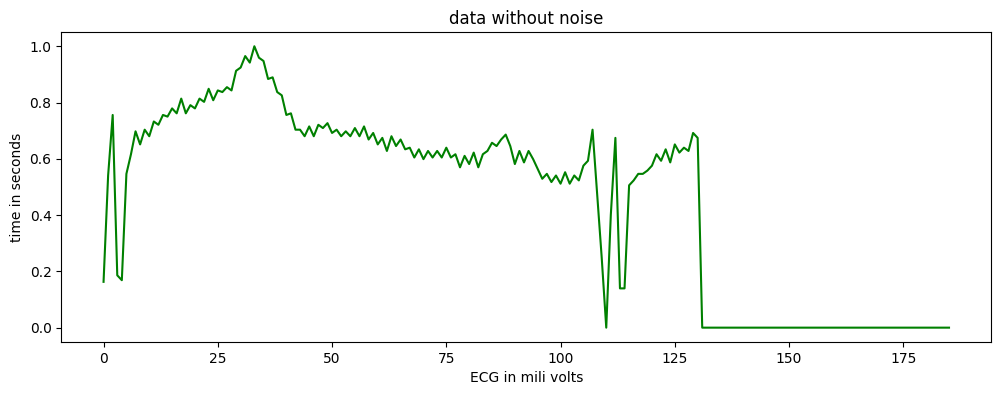

In [6]:
def add_gaussian_noise(signal):
    noise = np.random.normal(0,0.05,186)
    return(signal + noise)
noise_data = add_gaussian_noise(train_data.iloc[0,:186])
plt.figure(figsize = [12,4.02])
plt.plot(train_data.iloc[0,:186], color = 'green')
plt.title('data without noise')
plt.xlabel('ECG in mili volts')
plt.ylabel('time in seconds')

In [7]:
from sklearn.model_selection import train_test_split
X_train = train_data.drop(187, axis=1).values
y_train = train_data[187].values
X_test = test_data.drop(187, axis=1).values
y_test = test_data[187].values
unique, counts = np.unique(y_train, return_counts=True)

pd.DataFrame(np.asarray((unique, counts)).T)

0        1
0  0.0  20000.0
1  1.0  20000.0
2  2.0  20000.0
3  3.0  20000.0
4  4.0  20000.0

In [8]:
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

In [9]:
model = XGBClassifier()
model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [13]:
y_pred = model.predict(X_test)
print(f'Training Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
print(f'Testing Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Testing Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print("Recall Score : ",recall_score(y_test, y_pred, pos_label='positive', average='micro'))    
print("Precision Score : ",precision_score(y_test, y_pred,  pos_label='positive',average='micro'))     

print(f"Testing F-1:", f1_score(y_test, y_pred, pos_label='positive', average='micro'))

print(f"Testing F-Beta:", fbeta_score(y_test, y_pred, beta=0.5, pos_label='positive', average='micro'))
print('-'*30)

Training Accuracy: 0.99971
Testing Accuracy: 0.99971
Testing Confusion Matrix: 
[[19973    22     5     0     0]
 [    0 20000     0     0     0]
 [    2     0 19998     0     0]
 [    0     0     0 20000     0]
 [    0     0     0     0 20000]]
Recall Score :  0.99971
Precision Score :  0.99971
Testing F-1: 0.99971
Testing F-Beta: 0.99971
------------------------------


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classifi

Normalized confusion matrix


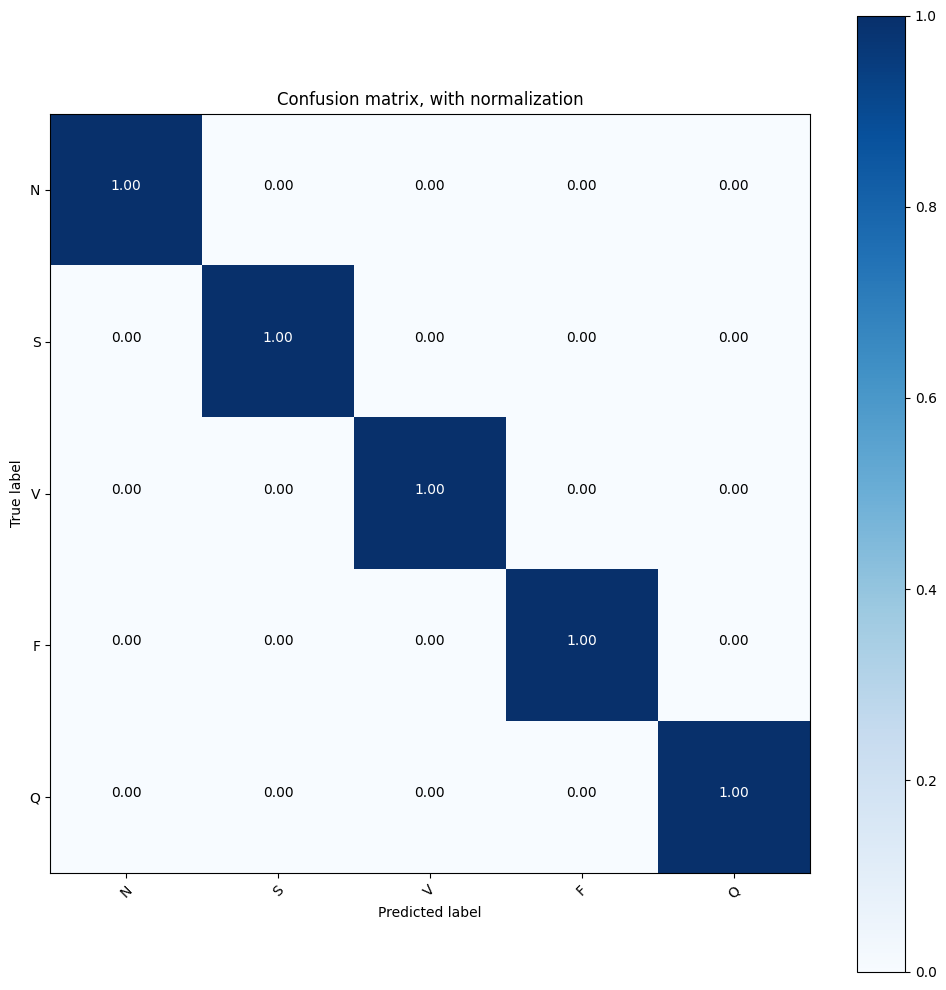

In [12]:
import itertools
from keras.utils.np_utils import to_categorical

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(to_categorical(y_test).argmax(axis=1), to_categorical(y_pred).argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()